# Movie Recommender System

## 1. Importing Ratings and Movie Metadata

The data is contained in two CSV files named `movies_metadata.csv` and `ratings.csv`

`movies_metadata` contains the following columns: 

- `movie_id`: Unique identifier of each movie. 
- `title`: Title of the movie. 
- `overview`: Short description of the movie. 
- `vote_average`: Average score the movie got.
- `vote_count`: Total number of votes the movie got. 

`ratings` contains the following columns: 

- `user_id`: Unique identifier of the person who rated the movie. 
- `movie_id`: Unique identifier of the movie. 
- `rating`: Value between 0 and 10 indicating how much the person liked the movie. 

In [114]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
# Read the movies_metadata file
movies_path = 'movies_metadata.csv'
movies_metadata = pd.read_csv(movies_path, low_memory=False)

# Read the ratings file
ratings_path = 'ratings.csv'
ratings = pd.read_csv(ratings_path)

In [116]:
# Analyze the data
# Display the first few rows of the movies metadata
movies_metadata.head()

,movie_id,title,overview,vote_average,vote_count
0,95765.0,Cinema Paradiso,"A filmmaker recalls his childhood, when he fel...",8.2,834.0
1,67116.0,The French Connection,Tough narcotics detective 'Popeye' Doyle is in...,7.4,435.0
2,80801.0,The Gods Must Be Crazy,Misery is brought to a small group of Sho in t...,7.1,251.0
3,96446.0,Willow,Fearful of a prophecy stating that a girl chil...,6.9,484.0
4,112697.0,Clueless,"Shallow, rich and socially successful Cher is ...",6.9,828.0


In [117]:
# Analyze the ratings data
# Display the first few rows of the ratings data
ratings.head()

,user_id,movie_id,rating
0,2,113862.0,3.0
1,2,114898.0,3.0
2,2,109444.0,4.0
3,2,109830.0,3.0
4,2,111257.0,3.0


In [118]:
# Display some movies metadata information
movies_metadata.info()
movies_metadata.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9010 entries, 0 to 9009
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_id      9010 non-null   float64
 1   title         9010 non-null   object 
 2   overview      8998 non-null   object 
 3   vote_average  9010 non-null   float64
 4   vote_count    9010 non-null   float64
dtypes: float64(3), object(2)
memory usage: 352.1+ KB


,movie_id,vote_average,vote_count
count,9.010000e+03,9010.000000,9010.000000
mean,4.716779e+05,6.364184,441.405771
std,7.268185e+05,1.031710,999.357265
min,4.170000e+02,0.000000,0.000000
25%,8.885875e+04,5.800000,29.000000
50%,1.196825e+05,6.500000,97.000000
75%,4.250440e+05,7.000000,368.000000
max,5.794766e+06,10.000000,14075.000000


In [119]:
# Display some ratings information
ratings.info()
ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99793 entries, 0 to 99792
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   99793 non-null  int64  
 1   movie_id  99793 non-null  float64
 2   rating    99793 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 2.3 MB


,user_id,movie_id,rating
count,99793.000000,9.979300e+04,99793.000000
mean,346.978155,2.458532e+05,3.543209
std,195.167518,4.042449e+05,1.057939
min,1.000000,4.170000e+02,0.500000
25%,182.000000,9.382200e+04,3.000000
50%,367.000000,1.139720e+05,4.000000
75%,520.000000,1.962290e+05,4.000000
max,671.000000,5.794766e+06,5.000000


In [120]:
# Get the total number of unique movies from the metadata
unique_movies = movies_metadata['movie_id'].nunique()

# Get the total number of distinct users who have rated at least one movie
unique_users = ratings['user_id'].nunique()

# Get the number of unique movies that have received at least one rating
unique_rated_movies = ratings['movie_id'].nunique()

print(f"Number of unique movies: {unique_movies}")
print(f"Number of unique users: {unique_users}")
print(f"Number of unique rated movies: {unique_rated_movies}")

Number of unique movies: 9010
Number of unique users: 671
Number of unique rated movies: 9010


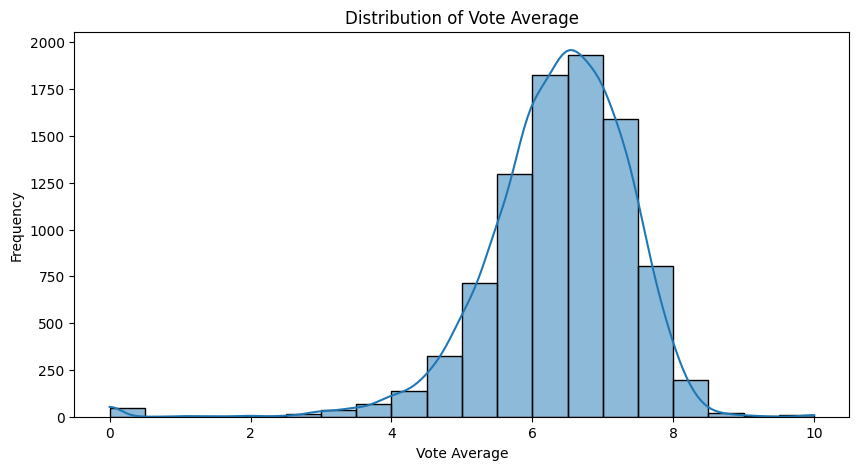

In [121]:
# Visualise the vote_average column
plt.figure(figsize=(10, 5))
sns.histplot(movies_metadata['vote_average'], bins=20, kde=True)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

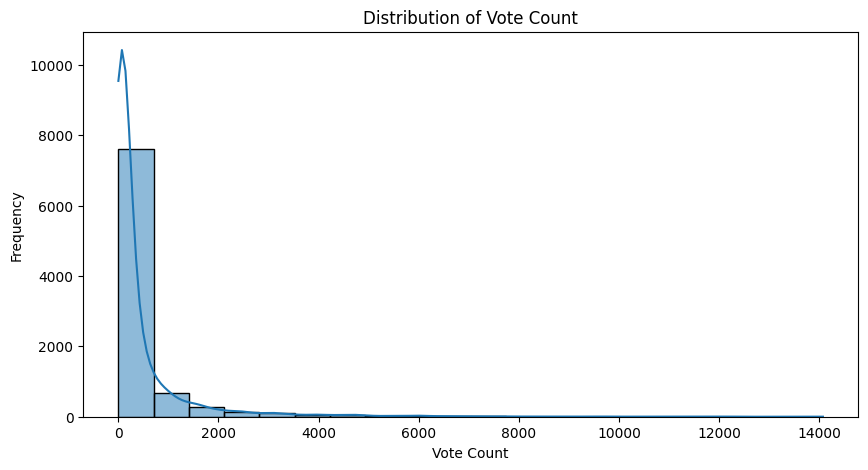

In [122]:
# Visualise the vote_count column
plt.figure(figsize=(10, 5))
sns.histplot(movies_metadata['vote_count'], bins=20, kde=True)
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.show()

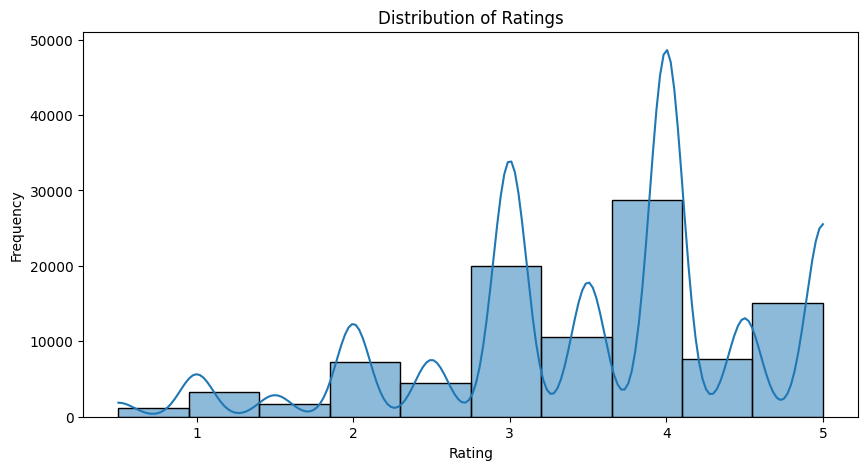

In [123]:
# Visualise the distribution of the rating column
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Analyzing User Rating Patterns

When we take a closer look at the user ratings, an interesting pattern emerges: certain scores appear far more frequently than others.

Unlike traditional scales ranging from 1 to 10, this dataset uses a **0.5 to 5.0 scale**, incremented by 0.5. Despite the availability of half-point ratings, users overwhelmingly favor **whole numbers** — such as 1.0, 2.0, 3.0, 4.0, and 5.0.

This suggests a **user bias toward "full" scores**, possibly due to habit, simplicity, or personal preference, effectively reducing the granularity of the rating system in practice.

## 2. Recomendations based on popularity or highest rating

In [124]:
def simple_recommender(criterion='vote_average', top_n=10):
    """
    Generate a simple recommender based on the specified criterion.
    
    Parameters:
    - criterion (str): Criterion to base recommendations on ('vote_average' or 'vote_count').
    - top_n (int): Number of top movies to recommend.
    
    Returns:
    - DataFrame: Top recommended movies based on the specified criterion.
    """
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")    
    # Sort movies by the specified criterion in descending order
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    # Select the top N movies
    top_recommended_movies = recommended_movies.head(top_n)

    return top_recommended_movies[['movie_id', 'title', 'overview', criterion]]

In [125]:
# Sample usage of the recommender function
top_movies_by_average = simple_recommender(criterion='vote_average', top_n=10)
top_movies_by_count = simple_recommender(criterion='vote_count', top_n=10)

# Display the top movies by average rating and count
print("Top movies by Average:\n", top_movies_by_average[['title', 'vote_average']])
print("\n Top movies by Count:\n", top_movies_by_count[['title', 'vote_count']])

Top movies by Average:
                                          title  vote_average
8907                                  Reckless          10.0
8363    Carmen Miranda: Bananas Is My Business          10.0
7463    Common Threads: Stories from the Quilt          10.0
6603                   Chilly Scenes of Winter          10.0
873                      Dancer, Texas Pop. 81          10.0
430                        Survive and Advance          10.0
2882  The Haunted World of Edward D. Wood, Jr.          10.0
1910                             The Civil War           9.2
6136                                    Cosmos           9.1
4329                      Little Miss Broadway           9.0

 Top movies by Count:
                         title  vote_count
67                  Inception     14075.0
5577          The Dark Knight     12269.0
5761                   Avatar     12114.0
8033             The Avengers     12000.0
6935                 Deadpool     11444.0
278              Interstellar

In [126]:
# Maybe we can just...
movies_metadata.sort_values(by='vote_count', ascending=False).head(10)

,movie_id,title,overview,vote_average,vote_count
67,1375666.0,Inception,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0
5577,468569.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,8.3,12269.0
5761,499549.0,Avatar,"In the 22nd century, a paraplegic Marine is di...",7.2,12114.0
8033,848228.0,The Avengers,When an unexpected enemy emerges and threatens...,7.4,12000.0
6935,1431045.0,Deadpool,Deadpool tells the origin story of former Spec...,7.4,11444.0
278,816692.0,Interstellar,Interstellar chronicles the adventures of a gr...,8.1,11187.0
6711,1853728.0,Django Unchained,"With the help of a German bounty hunter, a fre...",7.8,10297.0
1360,2015381.0,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",7.9,10014.0
7828,137523.0,Fight Club,A ticking-time-bomb insomniac and a slippery s...,8.3,9678.0
4484,1392170.0,The Hunger Games,Every year in the ruins of what was once North...,6.9,9634.0


## 3. Recommendations based on user ratings

In [127]:
# Imports
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [128]:
# Merge movies metadata with ratings
movies_ratings = pd.merge(ratings, movies_metadata, on='movie_id')

In [129]:
# Create a pivot table with users as rows and movies as columns
user_movie_ratings = movies_ratings.pivot_table(index='user_id', columns='title', values='rating')

In [130]:
# Fill NaN values with 0 (assuming unrated movies have a rating of 0)
user_movie_ratings = user_movie_ratings.fillna(0)

In [131]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(user_movie_ratings.T)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)

In [132]:
def get_recommendations(movie_title, cosine_sim_df, num_recommendations=10):
    # Get the similarity scores for the given movie
    sim_scores = cosine_sim_df[movie_title]
    # Sort the movies based on the similarity scores
    sim_scores = sim_scores.sort_values(ascending=False)
    # Get the top N recommendations (excluding the input movie itself)
    top_recommendations = sim_scores.iloc[1:num_recommendations+1]
    
    return top_recommendations

In [133]:
# 📽️ Example: Get recommendations for a specific movie
movie_title = "Toy Story"  # You can replace this with any movie title from your dataset
recommendations = get_recommendations(movie_title, cosine_sim_df)
# 📋 Display the recommended movies
for i, title in enumerate(recommendations.index[:10]):
    print(i + 1, title)

1 Toy Story 2
2 Star Wars
3 Forrest Gump
4 Independence Day
5 Groundhog Day
6 Back to the Future
7 Jurassic Park
8 Shrek
9 Return of the Jedi
10 Pulp Fiction


## 4. Generating Embeddings from Movie Descriptions

So far, we’ve built two types of movie recommenders:  
1. A **popularity-based** system that doesn’t consider your personal taste.  
2. A **content-based** recommender that suggests movies similar to one you've already seen.

Now, let's take it a step further — this time, **you** get to describe the kind of movie you’d like to watch, and we’ll return personalized recommendations based on your custom input!

To make this work, we’ll use a powerful concept called **embeddings**.  
Embeddings are numerical representations of text that capture its meaning in a format that computers can understand. They play a key role in modern AI systems — including models like ChatGPT.

In our case, we’ll take the movie descriptions from the dataset and convert them into embeddings. This will allow us to compare your custom input against all movies and find the best semantic matches.

In [134]:
# Imports
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [135]:
# Load a pre-trained model from Sentence Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

In [136]:
# Ensure the 'overview' column is filled with strings
movies_metadata['overview'] = movies_metadata['overview'].fillna('').astype(str)

# Generate embeddings for each movie overview
tqdm.pandas(desc="Generating embeddings")
movies_metadata['embedding'] = movies_metadata['overview'].progress_apply(lambda x: model.encode(x).tolist())

Generating embeddings: 100%|██████████| 9010/9010 [02:08<00:00, 70.14it/s]


## 5. Recommendations based on embeddings

In [137]:
def recommend_movies(user_input, movies_metadata, model, top_n=5):
    # Generate embedding for the user input
    user_embedding = model.encode(user_input).tolist()
    # Calculate cosine similarity between user input embedding and all movie embeddings
    movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
    # Sort movies by similarity in descending order and get the top n movies
    top_movies = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return top_movies[['title', 'overview', 'similarity']]

In [138]:
# Example usage
# user_input = "A story about a young wizard who discovers his magical heritage."
user_input = input("Describe the type of movie you're in the mood for: ") # Choose between user input or a predefined string
top_n = 5
recommended_movies = recommend_movies(user_input, movies_metadata, model, top_n)
recommended_movies

,title,overview,similarity
2530,Night of the Living Dead,A group of people try to survive an attack of ...,0.621708
3593,Dawn of the Dead,A group of surviving people take refuge in a s...,0.602829
3093,The Revenant,A horror movie/buddy comedy about Joey and his...,0.600095
4887,Day of the Dead,"The final chapter of George A. Romero's ""Dead ...",0.596398
4695,Warm Bodies,After a zombie becomes involved with the girlf...,0.593315


## 6. Put it all together in a single Function

In [139]:
def recommend_movies(method='vote_average', movie_title=None, user_prompt=None, top_n=10):
    if method == 'vote_average':
        # Recommender based on vote_average or vote_count
        recommended = movies_metadata.sort_values(by=['vote_average', 'vote_count'], ascending=False).head(top_n)
        return recommended[['title', 'overview', 'vote_average', 'vote_count']]
    
    elif method == 'similar_movies' and movie_title:
        # Recommender based on the ratings data where the most similar movies would be returned for a given movie title
        movie_id = movies_metadata[movies_metadata['title'] == movie_title]['movie_id'].values[0]
        user_ratings = ratings[ratings['movie_id'] == movie_id]
        similar_users = ratings[ratings['user_id'].isin(user_ratings['user_id'])]
        similar_movies = similar_users.groupby('movie_id').agg({'rating': 'mean'}).reset_index()
        similar_movies = similar_movies.merge(movies_metadata, on='movie_id')
        similar_movies = similar_movies.sort_values(by='rating', ascending=False).head(top_n)
        return similar_movies[['title', 'overview', 'rating']]
    
    elif method == 'embedding' and user_prompt:
        # Recommender based on the movie embeddings that are most similar to a user-generated prompt
        user_embedding = np.mean([movies_metadata[movies_metadata['title'] == title]['embedding'].values[0] for title in user_prompt], axis=0)
        movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
        recommended = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
        return recommended[['title', 'overview', 'similarity']]
    
    else:
        raise ValueError("Invalid method or missing parameters")

In [140]:
# 1. Vote Average Recommender
print("🔝 Top 5 Movies by Vote Average:\n")
vote_df = recommend_movies(method='vote_average', top_n=5)
print(vote_df[['title', 'vote_average', 'vote_count']].to_string(index=False))

print("\n" + "-"*60 + "\n")

# 2. Similar Movies Recommender
print("🎯 Top 5 Movies Similar to 'Mars Attacks!':\n")
similar_df = recommend_movies(method='similar_movies', movie_title='The Matrix', top_n=5)
print(similar_df[['title', 'rating']].to_string(index=False))

print("\n" + "-"*60 + "\n")

# 3. Embedding-based Recommender
print("🧠 Top 10 Movies Based on Embedding Similarity with ['Alien', 'Apocalypse Now']:\n")
embedding_df = recommend_movies(method='embedding', user_prompt=['Alien', 'Apocalypse Now'], top_n=10)
print(embedding_df[['title', 'similarity']].to_string(index=False))


🔝 Top 5 Movies by Vote Average:

                                   title  vote_average  vote_count
                     Survive and Advance          10.0         2.0
  Common Threads: Stories from the Quilt          10.0         2.0
                   Dancer, Texas Pop. 81          10.0         1.0
The Haunted World of Edward D. Wood, Jr.          10.0         1.0
                 Chilly Scenes of Winter          10.0         1.0

------------------------------------------------------------

🎯 Top 5 Movies Similar to 'Mars Attacks!':

                    title  rating
                 Phantoms     5.0
      A Face in the Crowd     5.0
Knockin' on Heaven's Door     5.0
         That Old Feeling     5.0
          Taste of Cherry     5.0

------------------------------------------------------------

🧠 Top 10 Movies Based on Embedding Similarity with ['Alien', 'Apocalypse Now']:

                    title  similarity
                    Alien    0.743783
           Apocalypse Now    0.743

In [141]:
# popularity-based recommender 
def popularity_recommender(movies_metadata, criterion='vote_average', top_n=10):
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")
    # Sort movies by the specified criterion in descending order
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    # Select the top N movies
    top_recommended_movies = recommended_movies.head(top_n)
    
    return top_recommended_movies[['movie_id', 'title', 'overview', criterion]]

# user rating based recommender 
def rating_recommender(movie_title, cosine_sim_df, num_recommendations=10):
    # Get the similarity scores for the given movie
    sim_scores = cosine_sim_df[movie_title]
    # Sort the movies based on the similarity scores
    sim_scores = sim_scores.sort_values(ascending=False)
    # Get the top N recommendations (excluding the input movie itself)
    top_recommendations = sim_scores.iloc[1:num_recommendations+1]
    
    return top_recommendations

# movie description based recommender  
def movie_description_recommender(user_input, movies_metadata, model, top_n=5):
    # Generate embedding for the user input
    user_embedding = model.encode(user_input).tolist()
    # Calculate cosine similarity between user input embedding and all movie embeddings
    movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
    # Sort movies by similarity in descending order and get the top n movies
    top_movies = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return top_movies[['title', 'overview', 'similarity']]

In [146]:
def movie_night_recommender(df, method = 'popularity', criterion = None, user_input = None, model = None, top_n = 5): 
    if method == 'popularity': 
        return popularity_recommender(df, criterion=criterion, top_n=top_n)
    elif method == 'rating_similarity': 
        return rating_recommender(movie_title = user_input, cosine_sim_df = df, num_recommendations = top_n) 
    elif method == 'movie_description': 
        return movie_description_recommender(user_input = user_input, movies_metadata = df, model = model, top_n=top_n) 
    else: 
        raise ValueError("Method must be one of: popularity, rating_similarity, or movie_description")

In [ ]:
# --- 1. Popularity-based Recommender ---
print("🎬 Top Movies by Popularity (vote_average):\n")
popularity_df = movie_night_recommender(
    df=movies_metadata,
    criterion='vote_average',
    top_n=5
)
print(popularity_df[['title', 'vote_average']].to_string(index=False))

print("\n" + "-"*50 + "\n")

# --- 2. Rating Similarity Recommender ---
movie_to_match = "The Matrix"
print(f"🎯 Top Movies Similar to '{movie_to_match}':\n")
similarity_df = movie_night_recommender(
    df = cosine_sim_df,
    method = 'rating_similarity',
    user_input = movie_to_match,
    top_n = 5
)
print(similarity_df.to_string())

print("\n" + "-"*50 + "\n")

# --- 3. Movie Description (Embedding) Recommender ---
user_prompt = "A futuristic sci-fi thriller with action and deep philosophical themes"
print(f"🧠 Top Movies Based on Your Description:\n\"{user_prompt}\"\n")
embedding_df = movie_night_recommender(
    df=movies_metadata,
    method='movie_description',
    user_input=user_prompt,
    model=model,
    top_n=5
)
print(embedding_df[['title', 'similarity']].to_string(index=False))

🎬 Top Movies by Popularity (vote_average):

                                 title  vote_average
                              Reckless          10.0
Carmen Miranda: Bananas Is My Business          10.0
Common Threads: Stories from the Quilt          10.0
               Chilly Scenes of Winter          10.0
                 Dancer, Texas Pop. 81          10.0

--------------------------------------------------

🎯 Top Movies Similar to 'The Matrix':

title
The Lord of the Rings: The Fellowship of the Ring    0.691844
The Lord of the Rings: The Two Towers                0.674486
Fight Club                                           0.654818
Back to the Future                                   0.651776
The Lord of the Rings: The Return of the King        0.647358

--------------------------------------------------

🧠 Top Movies Based on Your Description:
"A futuristic sci-fi thriller with action and deep philosophical themes"

              title  similarity
A Most Violent Year    0.583524